# Preview Raw RocketLogger Trace Data

```
Copyright (c) 2019, ETH Zurich, Computer Engineering Group
All rights reserved.

This work is licensed under the Creative Commons Attribution 4.0 International License.
To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/ or
send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.
```

The file is part of the dataset entiled *"Long-Term Tracing of Indoor Solar Harvesting"* which complements the following publication:

> L. Sigrist, A. Gomez, and L. Thiele.
> *"Dataset: Tracing Indoor Solar Harvesting."*
> In Proceedings of the 2nd Workshop on Data Acquisition To Analysis (DATA '19), 2019.
> [under submission]


The dataset is published and documented on Zenodo:

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3346976.svg)](https://doi.org/10.5281/zenodo.3346976)

**Description**

This Jupyter notebook directly imports and filters raw measuements of the *Indoor Solar Harvesting Dataset* stored in the [`raw/`](raw/) folder and plots a preview of the harvesting power for all measurement positions.

**Python package requirements**

The following Python packages are required to run this script: `matplotlib numpy pandas rocketlogger tables`

**Remarks regarding the timestamps**

- The timestamps are calculated from the measurement start time and the sample index, based on the sampling rate. The resulting dataset is likely to exhibit some drift in the timestamp, especially for longer, uninterrupted measurements (`DATASET_TIME_REFERENCE = 'relative'`).
- You may want to use `DATASET_TIME_REFERENCE = 'local'` to direclty use the Linux real-time clock timestamps, or use `DATASET_TIME_REFERENCE = 'network'` for a timer base that was synced with the network (see config line below the imports). While the first exhibits the drift over time similar to the `'relative'` timestamp calculation, the later timestamp is likely to introduce some jumps in the middle of the measurement.
- For early measurement traces the `'local'` and `'network'` traces may contain currupt timestamps. However, they are reliably detected during import with this script and filtered out. For this reason, the HDF5 dataset generated using those timestamp configurations may contain a time series shorter than that in the raw dataset. The default `'relative'` configuration always includes all raw data available.

For more details regarding the timestamp generation during the measurements check the documentation of the RocketLogger data format at <https://gitlab.ethz.ch/tec/public/rocketlogger/wikis/data-format#channel-data>.

In [1]:
import datetime
import os
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from rocketlogger.data import RocketLoggerData, RocketLoggerDataWarning

In [2]:
# path to raw data root folder and the position names
TRACE_DATA_PATH = './raw'
TRACE_POSITIONS = ['pos06', 'pos13', 'pos14', 'pos16', 'pos17', 'pos18']

# available time reference options
TRACE_TIME_REFERENCES = [
    'relative', # local sample index based, start time relative timestamp
    'local',    # local monotonic real-time clock timestamp
    'network',  # NTP synched and adjusted real-time clock timestamp
]

# correction of the real sampling rate (exact configured rate at 2.048 MHz clock; RocketLogger is using 49 PWM cycles at 100 MHz)
TRACE_SAMPLE_RATE_SCALING = (100e6 / 49) / 2.048e6

# time reference to use for the import
DATASET_TIME_REFERENCE = 'relative' # <<<--- you may want to change this configuration (see timestamp remarks)

# import decimation factor
DECIMATION_FACTOR = 10

# power measurement intervals to filter out by node name
POWER_FILTER = {
    'pos06': [
        ('2018-01-06T16:00:00', '2018-01-10T00:00:00'), # measurement file corrupted (indoor1_p27.rld)
    ],
}

In [3]:
# temporary suppress console output (http://thesmithfam.org/blog/2012/10/25/temporarily-suppress-console-output-in-python/)
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [4]:
# set matplotlib agg backend chunck size to avoid overflow errors in inline plots
mpl.rcParams['agg.path.chunksize'] = 10000

# explicitly register matplotlib time converters for pandas
register_matplotlib_converters()

In [5]:
def import_filter_node_traces(node_trace_directory, decimation_factor=1):
    '''
    Import power and ambient traces of a given RocketLogger intance
    
    :param node_trace_directory: The directly holding the recorded trace data
    
    :param decimation_factor: Import decimation factor for power traces
    
    :returns: tuple of the power and ambient sensor trace RocketLoggerData structures and data file paths
    '''
    
    ## collect files available for the node
    node_data_file_list = os.listdir(node_trace_directory)
    
    ## filter data files
    node_data_files = []
    for data_file_name in node_data_file_list:
        data_file_path = os.path.join(node_trace_directory, data_file_name)
        
        ## skip: non-files, non-RocketLogger data, RocketLogger partitioned files, ambient trace files
        if not os.path.isfile(data_file_path):
            continue
        if not data_file_path.endswith('.rld'):
            continue
        if re.match(r'.*_p\d+\.rld$', data_file_path):
            continue
        if re.match(r'.*-ambient(_p\d+)?\.rld$', data_file_path):
            continue

        ## add remaining file paths to file list
        node_data_files.append(data_file_path)
    
    ## load data from collected files in a list
    node_power_traces = []
    node_sensor_traces = []
    node_file_paths = []
    for data_file_path in node_data_files:
        power_trace = RocketLoggerData(data_file_path, join_files=True, decimation_factor=decimation_factor)
        
        ## merge current channels
        power_trace.merge_channels(keep_channels=True)

        ## import sensor data
        sensor_file_path = re.sub(r'.rld$', r'-ambient.rld', data_file_path)
        if os.path.isfile(sensor_file_path):
            sensor_trace = RocketLoggerData(sensor_file_path, join_files=True)
        else:
            print('Warning: No accompanying sensor data found ({}).'.format(data_file_path))
            sensor_trace = None
                
        node_power_traces.append(power_trace)
        node_sensor_traces.append(sensor_trace)
        node_file_paths.append(data_file_path)
    
    ## sort traces by time
    trace_start_times = [t._header['start_time'] for t in node_power_traces]
    sorted_index = [e[0] for e in sorted(enumerate(trace_start_times), key=lambda element: element[1])]
    node_power_traces = [node_power_traces[i] for i in sorted_index]
    node_sensor_traces = [node_sensor_traces[i] for i in sorted_index]
    node_file_paths = [node_file_paths[i] for i in sorted_index]
    
    return (node_power_traces, node_sensor_traces, node_file_paths)

## Import and preview available trace data

Loading data from `./raw/pos06`
clearing power data between 2018-01-06T16:00:00 and 2018-01-10T00:00:00


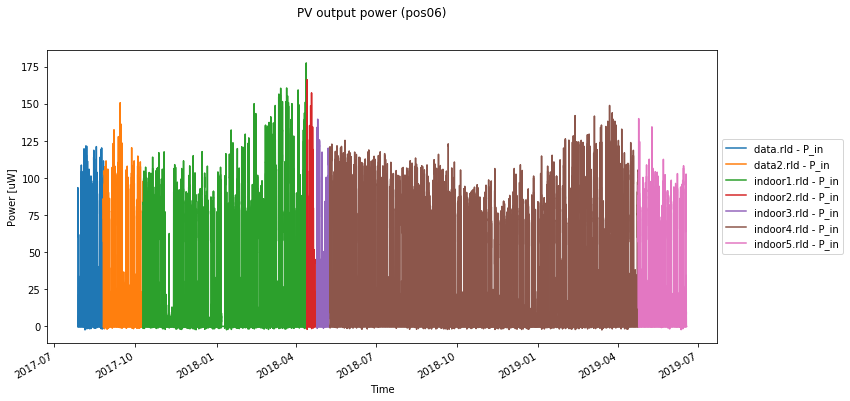

Loading data from `./raw/pos13`


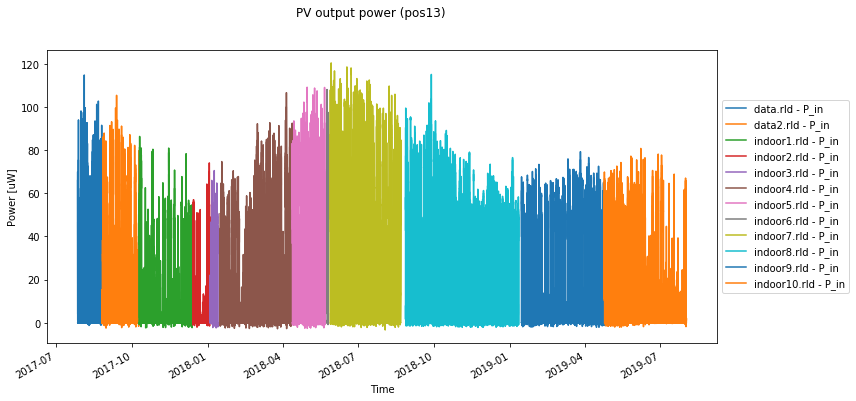

Loading data from `./raw/pos14`


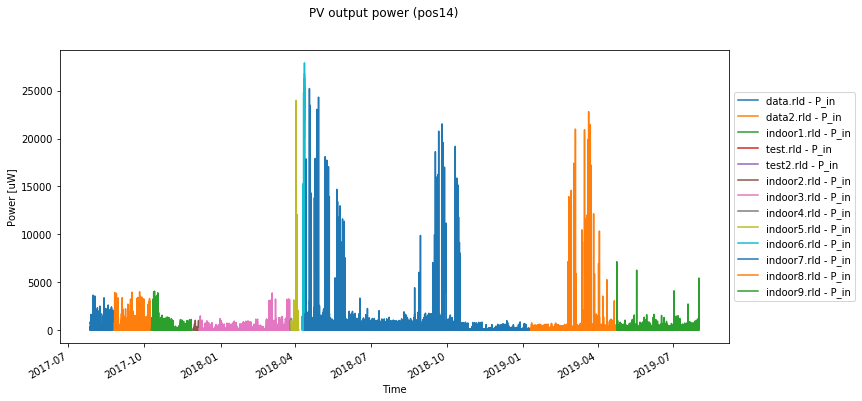

Loading data from `./raw/pos16`


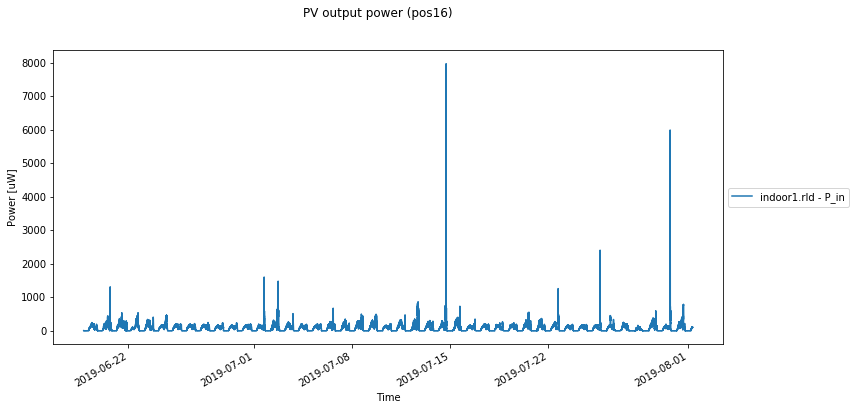

Loading data from `./raw/pos17`


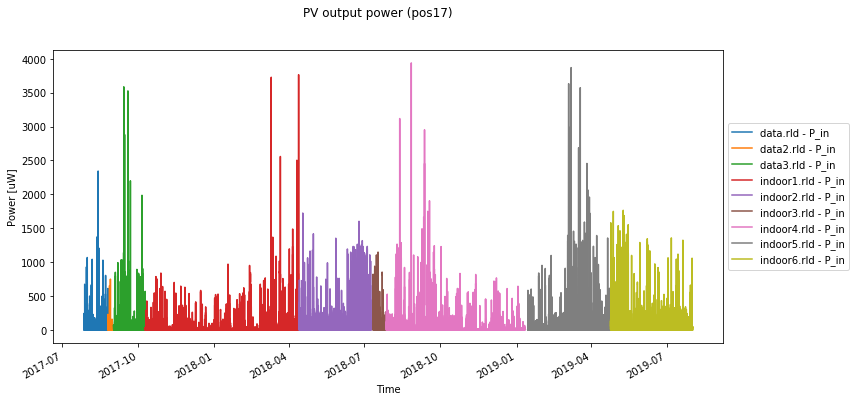

Loading data from `./raw/pos18`


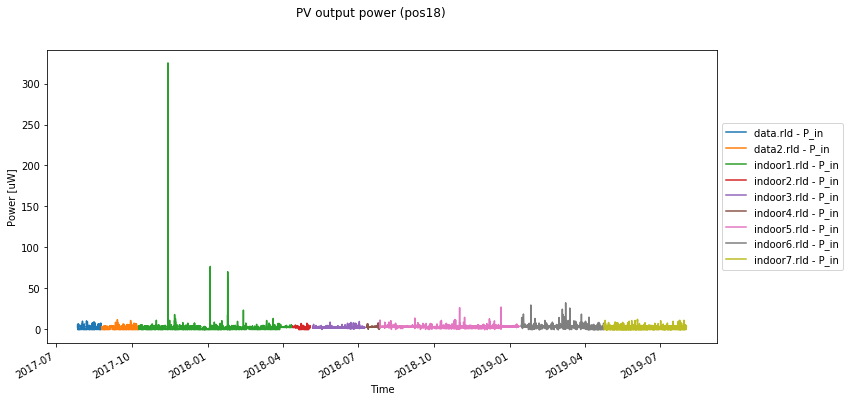

In [6]:
## load data for each host
for position in TRACE_POSITIONS:
    position_data_path = os.path.join(TRACE_DATA_PATH, position)
    print('Loading data from `{}`'.format(position_data_path))
    
    with suppress_stdout():
        (power_t, sensor_t, file_paths) = import_filter_node_traces(position_data_path, decimation_factor=DECIMATION_FACTOR)
    
    ## plot power trace
    [f, ax] = plt.subplots(1, 1, figsize=(12, 6))

    for (trace, file_path) in zip(power_t, file_paths):
        trace_filename = os.path.basename(file_path)
        
        ## get trace timestamp data
        trace_start_time = np.datetime64(trace._header['start_time'].replace(tzinfo=None))
        trace_timestamp_relative = trace.get_time(absolute_time=False)
        trace_timestamp_local = trace.get_time(absolute_time=True, time_reference='local')
        trace_timestamp_network = trace.get_time(absolute_time=True, time_reference='network')
        
        relative_timestamp_base = trace_start_time
        local_timestamp_offset = trace_start_time - trace_timestamp_local[0]
        absolute_timestamp_valid = np.abs(trace_timestamp_network[0] - trace_start_time) < np.timedelta64(1, 's')  # absolute timestamp bug in RocketLogger prior to v1.1.3 (#113)
        
        ## extract and check timestamp, skip files with warning if timestamp invalid
        trace_timestamp = None
        if DATASET_TIME_REFERENCE == 'network':
            if not absolute_timestamp_valid:
                print('Warning: skiping file `{}` with invalid network synced timestamp'.format(file_path))
                continue
            trace_timestamp = trace_timestamp_network
        elif DATASET_TIME_REFERENCE == 'local':
            if not absolute_timestamp_valid:
                print('Warning: skiping file `{}` with invalid local timestamp'.format(file_path))
                continue
            trace_timestamp = local_timestamp_offset + trace_timestamp_local
        elif DATASET_TIME_REFERENCE == 'relative':
            trace_timestamp = relative_timestamp_base + trace_timestamp_relative * (np.timedelta64(10**9, 'ns') / TRACE_SAMPLE_RATE_SCALING)
        else:
            raise ValueError('Invalid time_reference value')
        
        ## assemble data frame and perform filtering
        df = pd.DataFrame(trace.get_data(), index=trace_timestamp, columns=trace.get_channel_names())
        
        if position in POWER_FILTER.keys():
            for (filter_start, filter_end) in POWER_FILTER[position]:
                if df[filter_start:filter_end].size > 0:
                    index_start = np.array(df.index > filter_start).nonzero()[0].min()
                    index_end = np.array(df.index < filter_end).nonzero()[0].max()
                    print('clearing power data between {} and {}'.format(filter_start, filter_end))
                    df = df.drop(df.iloc[index_start:index_end].index)

        ## add labeled plot
        p = ax.plot(df.index, -1 * 1e6 * df['V1'] * df['I1'], alpha=1.0, label='{:s} - P_in'.format(trace_filename))

    _ = ax.set(xlabel='Time', ylabel='Power [uW]')
    _ = f.autofmt_xdate()
    _ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    _ = plt.suptitle('PV output power ({:s})'.format(position))
    plt.show()